<a href="https://colab.research.google.com/github/anirudh-g/Msc-Data-science/blob/master/Object_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip3 install detecto

In [2]:
!pip install torch==1.4

     |████████████████████████████████| 753.4MB 21kB/s 
ERROR: torchvision 0.7.0+cu101 has requirement torch==1.6.0, but you'll have torch 1.4.0 which is incompatible.
  Found existing installation: torch 1.6.0+cu101
    Uninstalling torch-1.6.0+cu101:
      Successfully uninstalled torch-1.6.0+cu101


In [3]:
!pip install torchvision==0.5.0

     |████████████████████████████████| 4.0MB 3.5MB/s 
  Found existing installation: torchvision 0.7.0+cu101
    Uninstalling torchvision-0.7.0+cu101:
      Successfully uninstalled torchvision-0.7.0+cu101


In [4]:
from detecto import core, utils, visualize
import torch
import numpy as np
import random
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import numpy as np
import tensorflow as tf
import glob

import torch
from torch.utils.data import Dataset
import json
import os
from PIL import Image

import xml.etree.ElementTree as ET
import torchvision.transforms.functional as FT

In [ ]:
print(torch.cuda.is_available())

True


In [6]:
import os
from google.colab import drive

drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/Object detection - directory')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!ls

 barchart.jpg		 images			 test.csv       val.csv
 bar-horizontal_1.png	 pred.txt		 test_labels    val_labels
'Copy of 2138674.jpeg'	 sample-bar-chart.jpg	 train.csv
 food-pie-chart.jpg	 smooth_line_chart.png	 train_labels


In [ ]:
#utils.xml_to_csv('train_labels', 'train.csv')
#utils.xml_to_csv('val_labels', 'val.csv')

,filename,width,height,class,xmin,ymin,xmax,ymax
0,bar98.jpg,1042,422,title,533,14,935,93
1,bar98.jpg,1042,422,legend,115,383,590,419
2,bar98.jpg,1042,422,axis label,8,24,29,99
3,bar81.jpg,481,289,title,221,18,328,46
4,bar91.jpg,448,224,legend,350,56,432,100
...,...,...,...,...,...,...,...,...
283,radar89.JPEG,602,391,title,61,15,577,33
284,radar89.JPEG,602,391,legend,28,46,158,132
285,scatter83.jpg,336,232,axis label,9,98,23,165
286,scatter83.jpg,336,232,axis label,145,206,203,225


In [ ]:
#Gaussian noise function inspired from https://www.oreilly.com/library/view/programming-pytorch-for/9781492045342/ch04.html
class Noise():
    def __init__(self, mean, stddev):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, img):
        self.stddev = np.random.exponential(self.stddev)
        noise = torch.zeros_like(img).normal_(self.mean, self.stddev)
        return img.add_(noise)

    def __repr__(self):
        repr = f"{self.__class__.__name__  }(mean={self.mean},stddev={self.stddev})"
        return repr

In [ ]:
transform_img = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize(224),
    transforms.ColorJitter(brightness=0.2),
    transforms.ToTensor(),
    Noise(mean=0.0, stddev=0.15), 
    utils.normalize_transform()
])

In [ ]:
dataset = core.Dataset('train.csv', 'images/', transform=transform_img)

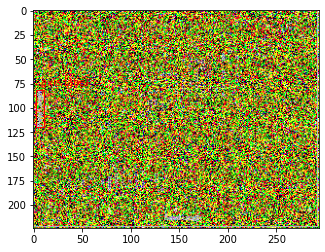

In [ ]:
from detecto.visualize import show_labeled_image

image, targets = dataset[1000]
visualize.show_labeled_image(image, targets['boxes'], targets['labels'])

In [ ]:
val_dataset = core.Dataset('val.csv', 'images/')

Epoch 1 of 5
Loss: 0.19540438143626992
Epoch 2 of 5
Loss: 0.1592806227854453
Epoch 3 of 5
Loss: 0.16032703150348324
Epoch 4 of 5
Loss: 0.152997743706995
Epoch 5 of 5
Loss: 0.15571472130250186


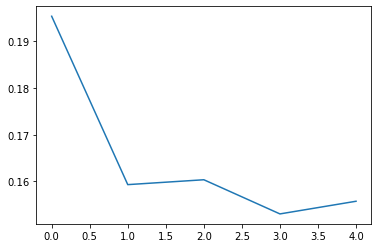

In [ ]:
model = core.Model(['title', 'legend', 'axis label'])

loader = core.DataLoader(dataset=dataset, shuffle=True)
losses = model.fit(loader, val_dataset, epochs=5, verbose=True, learning_rate=0.001)
plt.plot(losses)
plt.show()

In [ ]:
model.save('/content/drive/My Drive/Colab Notebooks/Obj det model noise.pth')

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving bar-horizontal.png to bar-horizontal.png


In [7]:
model2 = core.Model.load('/content/drive/My Drive/Colab Notebooks/Obj det model noise.pth', ['title', 'legend', 'axis label'])

In [8]:
images =[]
files = glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.jpg') + glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.jpeg') + glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.JPEG') + glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation/*.JPG')
for img in files:
  image2 = utils.read_image(img)
  images.append(image2)

In [ ]:
print(len(images))

140


In [32]:


l3=[]
s3=[]
b3=[]
for image in images:
  pred3 = model2.predict(image)
  l2 =[]
  b2=[]
  s2=[]
  for l_loop, b_loop, s_loop in zip(*pred3):
    if s_loop > 0.5:
      l2.append(l_loop)
      b2.append(b_loop)
      s2.append(s_loop)
  l3.append(l2)
  s3.append(s2)
  b3.append(b2)

In [28]:
print(l3)

[['title', 'legend', 'axis label', 'legend'], ['title', 'legend'], ['axis label', 'axis label', 'title', 'legend'], ['title'], ['title', 'legend'], ['axis label', 'axis label'], ['title', 'axis label'], ['title', 'axis label'], ['axis label', 'legend', 'axis label'], ['axis label', 'title', 'title'], ['legend', 'axis label', 'axis label'], ['axis label', 'legend'], ['axis label', 'legend', 'axis label'], [], ['axis label', 'legend', 'axis label'], ['title'], ['title', 'axis label'], ['title'], ['title'], ['title', 'legend', 'axis label'], ['axis label', 'title', 'title'], [], [], ['title', 'axis label', 'axis label'], ['title'], ['legend', 'title', 'axis label', 'axis label', 'axis label'], ['legend', 'axis label', 'title', 'axis label'], ['title', 'legend'], ['axis label', 'axis label'], ['legend', 'title', 'axis label'], ['axis label', 'axis label'], ['title', 'legend'], ['title', 'axis label', 'legend'], ['title', 'legend'], ['legend'], ['title', 'legend'], ['title', 'axis label', '

In [29]:
print(s3)

[[tensor(0.9489), tensor(0.9454), tensor(0.7044), tensor(0.5212)], [tensor(0.8601), tensor(0.7051)], [tensor(0.8204), tensor(0.7895), tensor(0.7502), tensor(0.5197)], [tensor(0.6902)], [tensor(0.7974), tensor(0.7061)], [tensor(0.7278), tensor(0.6913)], [tensor(0.8794), tensor(0.6244)], [tensor(0.8767), tensor(0.8278)], [tensor(0.7329), tensor(0.7265), tensor(0.6106)], [tensor(0.8094), tensor(0.8049), tensor(0.6698)], [tensor(0.7619), tensor(0.6262), tensor(0.5334)], [tensor(0.8240), tensor(0.6609)], [tensor(0.7870), tensor(0.7848), tensor(0.7640)], [], [tensor(0.8691), tensor(0.8615), tensor(0.7205)], [tensor(0.9663)], [tensor(0.9013), tensor(0.8816)], [tensor(0.6914)], [tensor(0.9269)], [tensor(0.9282), tensor(0.8459), tensor(0.6129)], [tensor(0.7214), tensor(0.5987), tensor(0.5189)], [], [], [tensor(0.7876), tensor(0.5818), tensor(0.5261)], [tensor(0.8871)], [tensor(0.9636), tensor(0.9515), tensor(0.6019), tensor(0.5552), tensor(0.5401)], [tensor(0.8354), tensor(0.8182), tensor(0.605

In [35]:
print(b3)

[[tensor([ 11.9657,   2.6695, 123.0901,  15.1436]), tensor([201.8099,  68.6619, 234.3179, 101.1365]), tensor([231.0754, 182.1517, 255.7809, 193.0854]), tensor([ 13.5438, 158.7620, 211.6116, 176.9664])], [tensor([ 43.9703,   7.1465, 241.7280,  21.1045]), tensor([112.3136, 166.4566, 169.5984, 178.8831])], [tensor([536.6852, 731.8302, 682.0660, 765.4489]), tensor([  6.1892, 382.3308,  34.8848, 474.5214]), tensor([ 13.4813,  11.9538, 328.0172,  53.8548]), tensor([ 324.3607,  107.5657, 1054.6277,  144.4674])], [tensor([ 520.6955,   64.2909, 1033.8629,  144.3233])], [tensor([110.6345,   7.2259, 159.7248,  17.5395]), tensor([ 98.4184, 171.0920, 169.6729, 182.6293])], [tensor([383.9412, 471.7232, 498.4102, 491.3257]), tensor([  7.9441, 224.6968,  26.9644, 261.6542])], [tensor([ 10.9788,   3.5967, 182.4353,  21.1231]), tensor([ 11.6812, 218.3848,  72.7864, 228.9425])], [tensor([ 76.0477,   1.3982, 180.4203,  10.7196]), tensor([  2.1766,  69.5999,  10.7176, 120.2734])], [tensor([ 9.0720, 72.8696

In [21]:
s3 = [torch.cat(s) for s in s3]

RuntimeError: ignored

In [30]:
s3 = [torch.stack(s) if len(s) > 0 else None for s in s3]

In [31]:
print(s3)

[tensor([0.9489, 0.9454, 0.7044, 0.5212]), tensor([0.8601, 0.7051]), tensor([0.8204, 0.7895, 0.7502, 0.5197]), tensor([0.6902]), tensor([0.7974, 0.7061]), tensor([0.7278, 0.6913]), tensor([0.8794, 0.6244]), tensor([0.8767, 0.8278]), tensor([0.7329, 0.7265, 0.6106]), tensor([0.8094, 0.8049, 0.6698]), tensor([0.7619, 0.6262, 0.5334]), tensor([0.8240, 0.6609]), tensor([0.7870, 0.7848, 0.7640]), None, tensor([0.8691, 0.8615, 0.7205]), tensor([0.9663]), tensor([0.9013, 0.8816]), tensor([0.6914]), tensor([0.9269]), tensor([0.9282, 0.8459, 0.6129]), tensor([0.7214, 0.5987, 0.5189]), None, None, tensor([0.7876, 0.5818, 0.5261]), tensor([0.8871]), tensor([0.9636, 0.9515, 0.6019, 0.5552, 0.5401]), tensor([0.8354, 0.8182, 0.6053, 0.5539]), tensor([0.9176, 0.7465]), tensor([0.8467, 0.5832]), tensor([0.9013, 0.5599, 0.5223]), tensor([0.7873, 0.7587]), tensor([0.9354, 0.8023]), tensor([0.8385, 0.7963, 0.6991]), tensor([0.8824, 0.7998]), tensor([0.8974]), tensor([0.8930, 0.7848]), tensor([0.8600, 0.7

In [36]:
b3 = [torch.stack(b) if len(b) > 0 else None for b in b3]

In [37]:
print(b3)

[tensor([[ 11.9657,   2.6695, 123.0901,  15.1436],
        [201.8099,  68.6619, 234.3179, 101.1365],
        [231.0754, 182.1517, 255.7809, 193.0854],
        [ 13.5438, 158.7620, 211.6116, 176.9664]]), tensor([[ 43.9703,   7.1465, 241.7280,  21.1045],
        [112.3136, 166.4566, 169.5984, 178.8831]]), tensor([[ 536.6852,  731.8302,  682.0660,  765.4489],
        [   6.1892,  382.3308,   34.8848,  474.5214],
        [  13.4813,   11.9538,  328.0172,   53.8548],
        [ 324.3607,  107.5657, 1054.6277,  144.4674]]), tensor([[ 520.6955,   64.2909, 1033.8629,  144.3233]]), tensor([[110.6345,   7.2259, 159.7248,  17.5395],
        [ 98.4184, 171.0920, 169.6729, 182.6293]]), tensor([[383.9412, 471.7232, 498.4102, 491.3257],
        [  7.9441, 224.6968,  26.9644, 261.6542]]), tensor([[ 10.9788,   3.5967, 182.4353,  21.1231],
        [ 11.6812, 218.3848,  72.7864, 228.9425]]), tensor([[ 76.0477,   1.3982, 180.4203,  10.7196],
        [  2.1766,  69.5999,  10.7176, 120.2734]]), tensor([[  9.

In [26]:
print(len(s3))

140


In [ ]:
print(l2)

['title', 'legend', 'axis label', 'legend', 'title', 'legend', 'axis label', 'axis label', 'title', 'legend', 'title', 'title', 'legend', 'axis label', 'axis label', 'title', 'axis label', 'title', 'axis label', 'axis label', 'legend', 'axis label', 'axis label', 'title', 'title', 'legend', 'axis label', 'axis label', 'axis label', 'legend', 'axis label', 'legend', 'axis label', 'axis label', 'legend', 'axis label', 'title', 'title', 'axis label', 'title', 'title', 'title', 'legend', 'axis label', 'axis label', 'title', 'title', 'title', 'axis label', 'axis label', 'title', 'legend', 'title', 'axis label', 'axis label', 'axis label', 'legend', 'axis label', 'title', 'axis label', 'title', 'legend', 'axis label', 'axis label', 'legend', 'title', 'axis label', 'axis label', 'axis label', 'title', 'legend', 'title', 'axis label', 'legend', 'title', 'legend', 'legend', 'title', 'legend', 'title', 'axis label', 'axis label', 'axis label', 'axis label', 'axis label', 'axis label', 'axis labe

In [ ]:
l =[]
b=[]
s=[]
for image in images:
  pred2 = model2.predict(image)
  labels2, boxes2, scores2 = pred2
  l.append(labels2)
  b.append(boxes2)
  s.append(scores2)

In [ ]:
voc_labels = ('title', 'legend', 'axis label')
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}

In [ ]:
print(label_map)

{'title': 1, 'legend': 2, 'axis label': 3}


In [ ]:
label_map['background']=0

In [ ]:
print(label_map)

{'title': 1, 'legend': 2, 'axis label': 3, 'background': 0}


In [ ]:
print(l)

[['title', 'legend', 'axis label', 'legend', 'legend', 'legend', 'legend', 'legend'], ['title', 'legend', 'axis label', 'title', 'title'], ['axis label', 'axis label', 'title', 'legend', 'axis label', 'legend', 'legend', 'legend', 'axis label', 'legend'], ['title', 'legend', 'legend', 'axis label', 'legend', 'legend', 'legend', 'legend', 'legend'], ['title', 'legend', 'axis label', 'legend'], ['axis label', 'axis label', 'legend', 'legend', 'title', 'title', 'title', 'title', 'title', 'legend', 'legend', 'title', 'legend'], ['title', 'axis label', 'legend', 'title'], ['title', 'axis label', 'legend', 'axis label', 'axis label', 'axis label', 'legend'], ['axis label', 'legend', 'axis label', 'title', 'title'], ['axis label', 'title', 'title', 'axis label', 'legend', 'legend', 'legend', 'legend', 'legend', 'legend', 'axis label', 'legend'], ['legend', 'axis label', 'axis label', 'axis label', 'axis label', 'legend'], ['axis label', 'legend', 'axis label', 'axis label', 'title', 'axis lab

In [ ]:
print(b)

[tensor([[ 11.9657,   2.6695, 123.0901,  15.1436],
        [201.8099,  68.6619, 234.3179, 101.1365],
        [231.0754, 182.1517, 255.7809, 193.0854],
        [ 13.5438, 158.7620, 211.6116, 176.9664],
        [  0.0000, 153.3073, 257.9926, 181.7153],
        [137.2377, 157.4050, 253.0856, 178.7077],
        [  8.0813, 160.8215, 128.6749, 176.2643],
        [197.7301,  40.1532, 243.5343, 102.8862]]), tensor([[ 43.9703,   7.1465, 241.7280,  21.1045],
        [112.3136, 166.4566, 169.5984, 178.8831],
        [111.0788, 167.4719, 168.5630, 178.5811],
        [110.6846,   8.5295, 238.2871,  19.0059],
        [ 37.4838,   8.7672, 161.2269,  19.1038]]), tensor([[ 536.6852,  731.8302,  682.0660,  765.4489],
        [   6.1892,  382.3308,   34.8848,  474.5214],
        [  13.4813,   11.9538,  328.0172,   53.8548],
        [ 324.3607,  107.5657, 1054.6277,  144.4674],
        [ 920.6741,  108.2408, 1060.9335,  142.2192],
        [  37.7246,  106.0421,  490.7887,  143.7056],
        [  63.9020,  

In [ ]:
print(s)

[tensor([0.9489, 0.9454, 0.7044, 0.5212, 0.3718, 0.1669, 0.1219, 0.0654]), tensor([0.8601, 0.7051, 0.3194, 0.2017, 0.1761]), tensor([0.8204, 0.7895, 0.7502, 0.5197, 0.1841, 0.1197, 0.1163, 0.0802, 0.0711,
        0.0545]), tensor([0.6902, 0.2103, 0.2059, 0.1731, 0.0878, 0.0870, 0.0591, 0.0570, 0.0506]), tensor([0.7974, 0.7061, 0.0974, 0.0614]), tensor([0.7278, 0.6913, 0.4706, 0.3463, 0.3340, 0.3211, 0.2645, 0.2346, 0.1664,
        0.0784, 0.0660, 0.0561, 0.0537]), tensor([0.8794, 0.6244, 0.1701, 0.0507]), tensor([0.8767, 0.8278, 0.3475, 0.2094, 0.1496, 0.1429, 0.0511]), tensor([0.7329, 0.7265, 0.6106, 0.4981, 0.0965]), tensor([0.8094, 0.8049, 0.6698, 0.4792, 0.4466, 0.4434, 0.3267, 0.1642, 0.1105,
        0.0759, 0.0709, 0.0665]), tensor([0.7619, 0.6262, 0.5334, 0.4789, 0.4123, 0.0685]), tensor([0.8240, 0.6609, 0.2123, 0.1295, 0.0855, 0.0605]), tensor([0.7870, 0.7848, 0.7640, 0.0858]), tensor([0.3746, 0.2421, 0.2262, 0.0970, 0.0841, 0.0553]), tensor([0.8691, 0.8615, 0.7205, 0.2665, 0.2

In [ ]:
for x in l:
  for y in range(len(x)):
    x[y] = int(label_map[x[y]])

In [ ]:
print(l)

[[1, 2, 3, 2, 2, 2, 2, 2], [1, 2, 3, 1, 1], [3, 3, 1, 2, 3, 2, 2, 2, 3, 2], [1, 2, 2, 3, 2, 2, 2, 2, 2], [1, 2, 3, 2], [3, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2], [1, 3, 2, 1], [1, 3, 2, 3, 3, 3, 2], [3, 2, 3, 1, 1], [3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2], [2, 3, 3, 3, 3, 2], [3, 2, 3, 3, 1, 3], [3, 2, 3, 3], [2, 2, 1, 2, 1, 3], [3, 2, 3, 2, 2, 3, 1, 3], [1, 2, 3, 2, 3, 2], [1, 3, 3, 3, 3, 1, 3, 3], [1, 2, 3, 3, 3, 3, 3, 3, 2], [1], [1, 2, 3, 3, 2], [3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3], [1, 2, 3], [2, 1, 1], [1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 1, 1, 2, 1], [1, 3, 3, 3, 3, 3], [2, 1, 3, 3, 3, 3, 2, 3], [2, 3, 1, 3, 3, 1, 3, 2, 2, 2, 2, 2, 3], [1, 2, 2, 2, 3, 3, 3], [3, 3, 3], [2, 1, 3, 1, 1, 1, 2, 3, 1], [3, 3, 3, 2], [1, 2, 3, 1, 2, 3, 3, 1], [1, 3, 2, 1, 1, 2], [1, 2, 2, 3], [2, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 1], [1, 2, 3, 2], [1, 3, 3, 3, 3, 3, 2, 3, 1], [3, 3, 3, 3, 3, 3], [1, 2, 3, 3, 3, 2, 2, 2, 1, 2, 2], [2, 3, 2, 3, 2, 1, 1, 2, 2], [3, 1, 3, 3, 1, 3, 

In [ ]:
for x in range(len(l)):
  l[x] = np.asarray(l[x])

In [ ]:
print(l)

[array([1, 2, 3, 2, 2, 2, 2, 2]), array([1, 2, 3, 1, 1]), array([3, 3, 1, 2, 3, 2, 2, 2, 3, 2]), array([1, 2, 2, 3, 2, 2, 2, 2, 2]), array([1, 2, 3, 2]), array([3, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2]), array([1, 3, 2, 1]), array([1, 3, 2, 3, 3, 3, 2]), array([3, 2, 3, 1, 1]), array([3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2]), array([2, 3, 3, 3, 3, 2]), array([3, 2, 3, 3, 1, 3]), array([3, 2, 3, 3]), array([2, 2, 1, 2, 1, 3]), array([3, 2, 3, 2, 2, 3, 1, 3]), array([1, 2, 3, 2, 3, 2]), array([1, 3, 3, 3, 3, 1, 3, 3]), array([1, 2, 3, 3, 3, 3, 3, 3, 2]), array([1]), array([1, 2, 3, 3, 2]), array([3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3]), array([1, 2, 3]), array([2, 1, 1]), array([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3,
       1, 1, 2, 1]), array([1, 3, 3, 3, 3, 3]), array([2, 1, 3, 3, 3, 3, 2, 3]), array([2, 3, 1, 3, 3, 1, 3, 2, 2, 2, 2, 2, 3]), array([1, 2, 2, 2, 3, 3, 3]), array([3, 3, 3]), array([2, 1, 3, 1, 1, 1, 2, 3, 1]), array([3, 3, 3, 2]), array([1, 2, 3, 1, 2

In [ ]:
for x in range(len(l)):
  l[x] = torch.from_numpy(l[x]).type(torch.LongTensor)

In [ ]:
print(l)

[tensor([1, 2, 3, 2, 2, 2, 2, 2]), tensor([1, 2, 3, 1, 1]), tensor([3, 3, 1, 2, 3, 2, 2, 2, 3, 2]), tensor([1, 2, 2, 3, 2, 2, 2, 2, 2]), tensor([1, 2, 3, 2]), tensor([3, 3, 2, 2, 1, 1, 1, 1, 1, 2, 2, 1, 2]), tensor([1, 3, 2, 1]), tensor([1, 3, 2, 3, 3, 3, 2]), tensor([3, 2, 3, 1, 1]), tensor([3, 1, 1, 3, 2, 2, 2, 2, 2, 2, 3, 2]), tensor([2, 3, 3, 3, 3, 2]), tensor([3, 2, 3, 3, 1, 3]), tensor([3, 2, 3, 3]), tensor([2, 2, 1, 2, 1, 3]), tensor([3, 2, 3, 2, 2, 3, 1, 3]), tensor([1, 2, 3, 2, 3, 2]), tensor([1, 3, 3, 3, 3, 1, 3, 3]), tensor([1, 2, 3, 3, 3, 3, 3, 3, 2]), tensor([1]), tensor([1, 2, 3, 3, 2]), tensor([3, 1, 1, 3, 3, 1, 3, 3, 1, 1, 3, 3, 3]), tensor([1, 2, 3]), tensor([2, 1, 1]), tensor([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 2, 3, 1, 1,
        2, 1]), tensor([1, 3, 3, 3, 3, 3]), tensor([2, 1, 3, 3, 3, 3, 2, 3]), tensor([2, 3, 1, 3, 3, 1, 3, 2, 2, 2, 2, 2, 3]), tensor([1, 2, 2, 2, 3, 3, 3]), tensor([3, 3, 3]), tensor([2, 1, 3, 1, 1, 1, 2, 3, 1]), tensor([3,

In [ ]:
#def xml_to_list(xml_folder, output_file=None):
xml_list = []
box_gt2 = []
label_gt =[]
difficult_gt =[]
      # Loop through every XML file
for xml_file in glob.glob('/content/drive/My Drive/Colab Notebooks/object detection/Validation' + '/*.xml'):
          tree = ET.parse(xml_file)
          root = tree.getroot()

          filename = root.find('filename').text
          objects = root.findall('object')
          # Each object represents each actual image label
          box_gt =[]
          label_tmp =[]
          difficult_tmp=[]
          for member in objects:
              box = member.find('bndbox')
              row_1 = int(float(box[0].text)), int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text))
              
              #print(type(row_1))
              box_gt.append(list(row_1))
              #print(type(box_gt))
              
              label = member.find('name').text
              label_tmp.append(label)
              difficult = int(member.find('difficult').text)
              difficult_tmp.append(difficult)
              row = (filename, label, int(float(box[0].text)),
                    int(float(box[1].text)), int(float(box[2].text)), int(float(box[3].text)))
              xml_list.append(row)
          difficult_gt.append(difficult_tmp)
          label_gt.append(label_tmp)
          box_gt2.append(np.asarray(box_gt))
print(difficult_gt)
#print(box_gt2)
     # return xml_list

[[0, 0], [0, 0], [0, 0], [0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0], [0], [0, 0, 0, 0], [0, 0], [0, 0, 0, 0], [0, 0], [0, 0, 0], [0, 0, 0], [0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0], [0], [0, 0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0, 0], [0], [0], [0, 0, 0], [0, 0, 0], [0, 0], [0, 0, 0, 0], [0, 0, 0], [0, 0], [0, 0, 0, 0], [0], [0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0], [0, 0, 0, 0], [0, 0], [0, 0], [0, 0], [0, 0], [0, 0, 0, 0], [0, 0, 0, 0], [0, 0], [0, 0], [0], [0, 0, 0, 0], [0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0], [0], [0, 0, 0], [0], [0], [0, 0, 0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0], [0, 0], [0, 0], [0, 0], [0, 0], [0], [0, 0], [0], [0], [0], [0], [0], [0], [0, 0], [0, 0], [0], [0], [0, 0], [0], [0, 0], [0, 0], [0, 0], [0], [0], [0, 0], [0], [0], [0, 0], [0], [0], [0, 0], [0, 0], [0], [0, 0], [0], [0, 0], [0], [0], [0], [0, 0], [0, 0], [0], [0], [0, 0, 0], [0, 0], [0, 0], [0, 0], [0, 0],

In [ ]:
for x in range(len(difficult_gt)):
  difficult_gt[x] = np.asarray(difficult_gt[x])

In [ ]:
for x in range(len(difficult_gt)):
  difficult_gt[x] = torch.from_numpy(difficult_gt[x])

In [ ]:
print(difficult_gt)

[tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0]), tensor([0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0]), tensor([0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0]), tensor([0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0]), tensor([0, 0, 0, 0]), tensor([0, 0, 

In [ ]:
for x in label_gt:
  for y in range(len(x)):
    x[y] = int(label_map[x[y]])

In [ ]:
print(label_gt)

[[2, 3], [2, 3], [1, 2], [1, 2], [3, 3, 2], [1, 3, 2], [2, 3, 3], [1], [2], [1, 2, 3, 3], [1, 2], [1, 2, 3, 3], [1, 2], [2, 3, 3], [2, 3, 3], [1], [1, 2, 3], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2, 3], [3, 3], [1, 2], [1, 3], [1, 2], [3, 3], [1], [1], [1, 2], [1, 2, 3], [1, 3], [3, 3], [2, 1], [1, 2], [3, 3], [1, 2, 3], [2], [1], [2, 3, 3], [1, 3, 2], [1, 2], [1, 2, 3, 3], [1, 2, 3], [1, 3], [1, 2, 3, 3], [3], [2, 3], [1, 3, 2], [1, 3, 2], [1, 2, 3], [1, 2], [1, 2, 3, 3], [1, 3], [1, 3], [1, 3], [1, 3], [1, 2, 3, 3], [1, 3, 3, 2], [1, 2], [1, 3], [1], [1, 2, 3, 3], [1], [1, 3, 3], [1, 3, 3], [1, 3, 3], [1], [1], [3, 3, 3], [2], [1], [1, 3, 3], [1, 3, 3], [1, 2], [1, 2], [1, 2], [1], [1, 2], [3, 3], [1, 2], [1, 2], [1], [1, 2], [1], [1], [2], [2], [1], [1], [1, 2], [1, 2], [1], [2], [1, 2], [1], [1, 2], [1, 2], [1, 2], [2], [1], [1, 2], [1], [2], [1, 2], [1], [2], [1, 2], [1, 2], [2], [2, 1], [1], [1, 2], [2], [2], [1], [1, 2], [1, 2], [2], [1], [1, 3, 3], [3, 3], [3, 3], [3, 3], [3, 3],

In [ ]:
for x in range(len(label_gt)):
  label_gt[x] = np.asarray(label_gt[x])

In [ ]:
for x in range(len(label_gt)):
  label_gt[x] = torch.from_numpy(label_gt[x])

In [ ]:
print(label_gt)

[tensor([2, 3]), tensor([2, 3]), tensor([1, 2]), tensor([1, 2]), tensor([3, 3, 2]), tensor([1, 3, 2]), tensor([2, 3, 3]), tensor([1]), tensor([2]), tensor([1, 2, 3, 3]), tensor([1, 2]), tensor([1, 2, 3, 3]), tensor([1, 2]), tensor([2, 3, 3]), tensor([2, 3, 3]), tensor([1]), tensor([1, 2, 3]), tensor([1, 2]), tensor([1, 2]), tensor([1, 2]), tensor([1, 2]), tensor([1, 2, 3]), tensor([3, 3]), tensor([1, 2]), tensor([1, 3]), tensor([1, 2]), tensor([3, 3]), tensor([1]), tensor([1]), tensor([1, 2]), tensor([1, 2, 3]), tensor([1, 3]), tensor([3, 3]), tensor([2, 1]), tensor([1, 2]), tensor([3, 3]), tensor([1, 2, 3]), tensor([2]), tensor([1]), tensor([2, 3, 3]), tensor([1, 3, 2]), tensor([1, 2]), tensor([1, 2, 3, 3]), tensor([1, 2, 3]), tensor([1, 3]), tensor([1, 2, 3, 3]), tensor([3]), tensor([2, 3]), tensor([1, 3, 2]), tensor([1, 3, 2]), tensor([1, 2, 3]), tensor([1, 2]), tensor([1, 2, 3, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 3]), tensor([1, 2, 3, 3]), tensor([1, 3, 

In [ ]:
for x in range(len(box_gt2)):
  box_gt2[x] = torch.from_numpy(box_gt2[x])

In [ ]:
print(box_gt2)

[tensor([[ 52,  32, 221,  46],
        [ 11,  96,  30, 148]]), tensor([[ 14, 205, 219, 217],
        [  3,  57,  15, 117]]), tensor([[  6,   2, 128,  18],
        [200,  72, 235, 103]]), tensor([[107,   6, 161,  20],
        [ 98, 171, 172, 185]]), tensor([[  9,  46,  25,  90],
        [146, 139, 170, 155],
        [284,  51, 308, 115]]), tensor([[ 74,   2, 183,  12],
        [  3,  70,  12, 123],
        [ 60, 186, 200, 194]]), tensor([[207,   7, 245,  29],
        [110, 176, 135, 188],
        [  6,  71,  20,  99]]), tensor([[ 11,  16, 147,  32]]), tensor([[ 22, 168, 242, 183]]), tensor([[  4,   6, 102,  18],
        [109,  21, 195,  38],
        [  2,  79,  13, 111],
        [ 98, 158, 132, 165]]), tensor([[ 39,   7, 243,  23],
        [106, 166, 171, 179]]), tensor([[   8,   11,  340,   44],
        [  25,  100, 1061,  152],
        [ 528,  727,  699,  770],
        [   2,  375,   41,  497]]), tensor([[ 549,   57, 1058,  190],
        [  83,  765, 1549,  904]]), tensor([[ 78,  17, 

In [ ]:
print(len(box_gt2))

140


In [ ]:
print(len(b))

140


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
rev_label_map = {v: k for k, v in label_map.items()}

In [ ]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0))  # (n1, n2, 2)
    upper_bounds = torch.min(set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0))  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)


def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.
    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection  # (n1, n2)

    return intersection / union

In [ ]:
def calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties):
    
    assert len(det_boxes) == len(det_labels) == len(det_scores) == len(true_boxes) == len(
        true_labels) == len(
        true_difficulties)  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * len(true_labels[i]))
    true_images = torch.LongTensor(true_images).to(
        device)  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert det_images.size(0) == det_boxes.size(0) == det_labels.size(0) == det_scores.size(0)

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros((n_classes - 1), dtype=torch.float)  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[true_labels == c]  # (n_class_objects)
        n_easy_class_objects = (1 - true_class_difficulties).sum().item()  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros((true_class_difficulties.size(0)), dtype=torch.uint8).to(
            device)  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(det_class_scores, dim=0, descending=True)  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(device)  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[true_class_images == this_image]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[true_class_images == this_image]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(this_detection_box.type(torch.FloatTensor), object_boxes.type(torch.FloatTensor))  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            # We need 'original_ind' to update 'true_class_boxes_detected'

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.1:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = 1  # this object has now been detected/accounted for
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(true_positives, dim=0)  # (n_class_detections)
        cumul_false_positives = torch.cumsum(false_positives, dim=0)  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
                cumul_true_positives + cumul_false_positives + 1e-10)  # (n_class_detections)
        cumul_recall = cumul_true_positives / n_easy_class_objects  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=0.5, step=.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(device)  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())}

    return average_precisions, mean_average_precision

In [38]:
ap, map = calculate_mAP(b3, l3, s3, box_gt2, label_gt, difficult_gt )

NameError: ignored

In [ ]:
print(map)

0.10960168391466141


In [ ]:
print(ap)

{'title': 0.24956707656383514, 'legend': 0.039801377803087234, 'axis label': 0.039436619728803635}
